# PART 1. Data Pre-processing
## Step #0. Fire the system

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
plt.style.use('bmh')
import datetime as dt
from datetime import datetime, timedelta
# from google.colab import drive 
# drive.mount('/content/drive')

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

## Step #1. Read data

In [2]:
# Importing Training Set
df = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\QBDaily.csv', index_col=0, parse_dates=True)

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

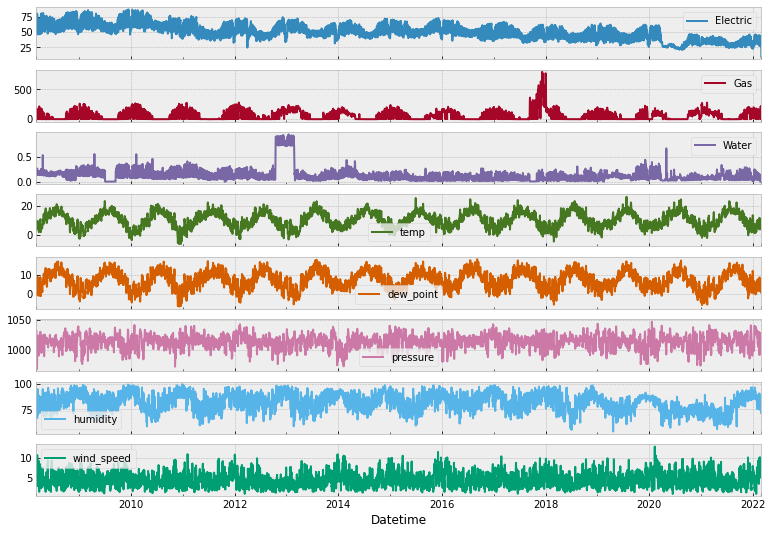

In [3]:
df.plot(subplots=True, figsize=(13,9))

In [4]:
df = df.loc[:'2020-03-15']
data = df.reset_index()

dataset_train = data.copy()

dataset_train

,Datetime,Electric,Gas,Water,temp,dew_point,pressure,humidity,wind_speed
0,2008-03-03,50.036833,187.283062,0.255979,4.422917,-0.175417,1010.041667,72.250000,5.371667
1,2008-03-04,79.146396,152.284854,0.252188,3.310000,-0.861250,1026.375000,75.208333,5.100000
2,2008-03-05,80.725021,151.048396,0.249979,4.049167,0.947083,1033.000000,80.291667,4.379167
3,2008-03-06,79.155750,102.277521,0.248687,9.252500,5.157500,1021.916667,75.791667,5.761250
4,2008-03-07,77.895188,102.198229,0.239896,7.638750,2.673333,1010.166667,71.750000,6.660833
...,...,...,...,...,...,...,...,...,...
4391,2020-03-11,57.187500,78.982833,0.268333,9.246667,5.750000,1005.875000,79.000000,7.485000
4392,2020-03-12,56.541667,93.385563,0.298146,5.965833,1.518750,1006.333333,73.625000,8.770833
4393,2020-03-13,58.270833,89.668729,0.258562,6.609167,3.384583,1015.791667,80.125000,4.647500
4394,2020-03-14,44.458333,72.013729,0.100937,8.076667,5.657917,1011.500000,84.791667,5.665833


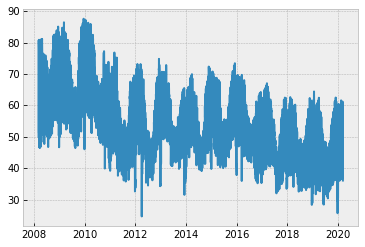

In [5]:
plt.plot(dataset_train['Datetime'], dataset_train['Electric'])

In [6]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Datetime'])
# datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (4396, 9)
All timestamps == 4396
Featured selected: ['Electric', 'Gas', 'Water', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed']


## Step #2. Data pre-processing
Removing all commas and convert data to matrix shape format.

In [7]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set[:1]

Shape of training set == (4396, 8).


array([[ 5.00368333e+01,  1.87283062e+02,  2.55979167e-01,
         4.42291667e+00, -1.75416667e-01,  1.01004167e+03,
         7.22500000e+01,  5.37166667e+00]])

In [8]:
# Feature Scaling
from sklearn.preprocessing import *

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.40334369],
       [0.86616533],
       [0.89126436],
       ...,
       [0.53425852],
       [0.31464945],
       [0.18149282]])

In [9]:
# Creating a data structure with 120 timestamps and 1 output
X_train = []
y_train = []

n_future = 780  # Number of days we want top predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1]) # Set dependent variables.
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0]) # Select target variable.

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3603, 14, 7).
y_train shape == (3603, 1).


# PART 2. Create a model. Training
## Step #3. Building the LSTM based Neural Network

In [10]:
# Import Libraries and packages from Keras
from keras.models import *
from keras.layers import *

In [11]:
# Initializing the Neural Network based on LSTM
# model = Sequential()
# model.add(LSTM(units=32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
# # model.add(LSTM(units=32, activation='relu', return_sequences=True))
# # model.add(LSTM(units=32, activation='relu', return_sequences=True))
# # model.add(LSTM(units=32, activation='relu', return_sequences=True))
# # model.add(LSTM(units=32, activation='relu', return_sequences=True))
# # model.add(LSTM(units=32, activation='relu', return_sequences=True))
# # model.add(LSTM(units=32, activation='relu', return_sequences=True))
# # model.add(LSTM(units=32, activation='relu'))
# model.add(Dropout(rate=0.2))
# # model.add(Dense(units=8, activation='relu'))
# model.add(Dense(units=1))
# model.summary()

model = Sequential()
model.add(Bidirectional(LSTM(units=14, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False)))
# model.add(Bidirectional(LSTM(units=14, activation='relu', return_sequences=True)))
# model.add(Bidirectional(LSTM(units=14, activation='relu', return_sequences=True)))
# model.add(Bidirectional(LSTM(units=14, activation='relu')))
# model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation='relu'))

# Compiling the Neural Network
model.compile(optimizer='adam', loss='mean_squared_error')

## Step #4. Start training

In [12]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=100, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)
mcp = ModelCheckpoint(filepath='weights1.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=1000, callbacks=[es, rlr, mcp, tb], validation_split=0.1, verbose=1)

Epoch 1/1000
 94/102 [==========================>...] - ETA: 0s - loss: 0.1814
Epoch 1: val_loss improved from inf to 0.02725, saving model to weights1.h5
102/102 [==============================] - 7s 15ms/step - loss: 0.1699 - val_loss: 0.0272 - lr: 0.0010
Epoch 2/1000
100/102 [============================>.] - ETA: 0s - loss: 0.0351
Epoch 2: val_loss improved from 0.02725 to 0.02648, saving model to weights1.h5
102/102 [==============================] - 1s 7ms/step - loss: 0.0349 - val_loss: 0.0265 - lr: 0.0010
Epoch 3/1000
 93/102 [==========================>...] - ETA: 0s - loss: 0.0303
Epoch 3: val_loss improved from 0.02648 to 0.02470, saving model to weights1.h5
102/102 [==============================] - 1s 6ms/step - loss: 0.0295 - val_loss: 0.0247 - lr: 0.0010
Epoch 4/1000
 94/102 [==========================>...] - ETA: 0s - loss: 0.0286
Epoch 4: val_loss improved from 0.02470 to 0.02359, saving model to weights1.h5
102/102 [==============================] - 1s 6ms/step - loss

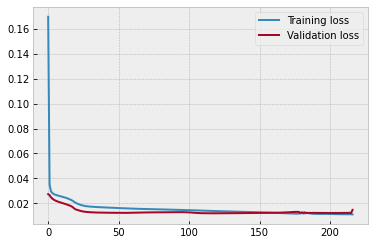

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

## PART 3. Make future predictions

In [14]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

## Step #5. Make predictions for future dates

In [15]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

predictions_train1 = model.predict(X_train)

## Step #6. Evaluate Metrics

In [16]:
from sklearn.metrics import *

print('RMSE: ', round(np.sqrt(mean_squared_error(y_train, predictions_train1)),3))
print('MSE: ', round(mean_squared_error(y_train, predictions_train1),3))
print('MAE: ', round(mean_absolute_error(y_train, predictions_train1),3))
print('R2: ', round(r2_score(y_train, predictions_train1),3))

RMSE:  0.102
MSE:  0.01
MAE:  0.08
R2:  0.605


In [17]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['value']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['value']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

In [18]:
datelist_train = pd.to_datetime(datelist_train)

In [19]:
dataset_train = dataset_train.set_index(datelist_train)

## Step #6. Visualize the Predictions

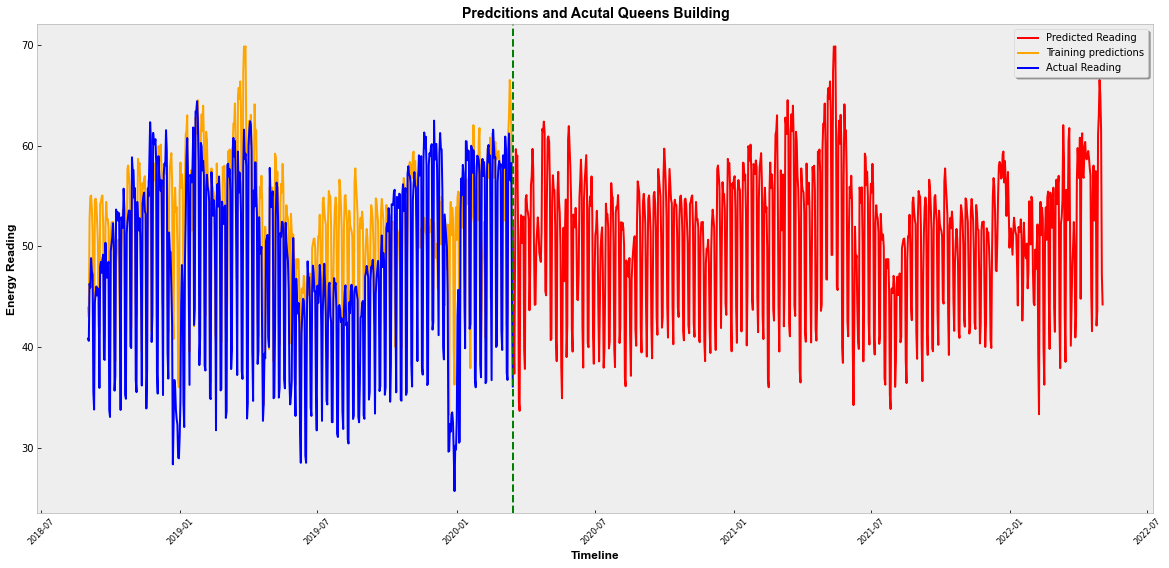

In [20]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 9

# Plot parameters
START_DATE_FOR_PLOTTING = '2018-09'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['value'], color='r', label='Predicted Reading')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['value'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Electric'], color='b', label='Actual Reading')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Queens Building', family='Arial', fontsize=14, fontweight='bold')
plt.xlabel('Timeline', family='Arial', fontsize=12, fontweight='bold')
plt.ylabel('Energy Reading', family='Arial', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=8)
plt.show()